In [198]:
#Import libraries
import pandas as pd
import numpy as np

# load packages
import scipy.stats as stats
import os
from statsmodels.formula.api import ols
import statsmodels.api as sm

import statsmodels.stats.multicomp
from statsmodels.graphics.api import interaction_plot, abline_plot

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random
import math
import statistics 

os.getcwd()
os.chdir('D:\Qurantine\Blog\ANOVA Test')


In [199]:
####Load Data
individualDetails=pd.read_csv('./individualDetails.csv',parse_dates=[2])
stateDensity=pd.read_csv('./stateDensity.csv')


In [200]:
individualDetails.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,State,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan
1,1,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan
2,2,KL-KS-P1,2020-03-02,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan
3,3,DL-P1,2020-02-03,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15-03-2020,"Travelled from Austria, Italy"
4,4,TS-P1,2020-02-03,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02-03-2020,"Travelled from Dubai to Bangalore on 20th Feb,..."


In [201]:
individualDetails[individualDetails['age']==0].shape # There's nobody with age=0

(0, 12)

In [202]:
individualDetails.dtypes

id                             int64
government_id                 object
diagnosed_date        datetime64[ns]
age                           object
gender                        object
detected_city                 object
detected_district             object
State                         object
nationality                   object
current_status                object
status_change_date            object
notes                         object
dtype: object

In [203]:
# Transform data in legit format
for index , row in individualDetails.iterrows():
    if not pd.isnull(row['age']):
        if len(row['age'].split('-'))>1:
                    individualDetails['age'][index]=round((int(row['age'].split('-')[0])+int(row['age'].split('-')[1]))/2)
        elif len(row['age'].split('.'))>1:    
            individualDetails['age'][index]=round(float(row['age']))
        else:
            pass

C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [204]:
#Check for missing values
individualDetails.isna().sum()

id                        0
government_id         24893
diagnosed_date            0
age                   25544
gender                22577
detected_city         25543
detected_district      7650
State                     0
nationality           25183
current_status            0
status_change_date      110
notes                  1335
dtype: int64

In [205]:
print('Percentage of missing values in age & gender columns respectively :', \
      (individualDetails['age'].isna().sum()/individualDetails.shape[0])*100,'%',\
      (individualDetails['gender'].isna().sum()/individualDetails.shape[0])*100,'%')

Percentage of missing values in age & gender columns respectively : 91.58838293295088 % 80.95016134815346 %


In [206]:
25544/individualDetails.shape[0]

0.9158838293295087

In [207]:
#We see that there're 25544 missing entires in age column i.e.almost 92% of overall Data Size. So in lieu of imputing
#missing values with median or Mode , I'll impute it with mean. 


In [208]:
ageMedianPerState=individualDetails[~individualDetails['age'].isna()]
ageMedianPerState['age']=ageMedianPerState['age'].astype(str).astype(int)

ageMedianPerState=ageMedianPerState.groupby('State')[['age']].median().reset_index()
ageMedianPerState['age']=ageMedianPerState['age'].apply(lambda x:math.ceil(x))

#Find the most frequent infected gender by COVID-19 for each state
genderModePerState=individualDetails.groupby(['State'])['gender'].agg(pd.Series.mode).to_frame().reset_index()
#Drop Arunachal Pradesh , Since this has got no informatio about gender overall
genderModePerState=genderModePerState[genderModePerState['State']!='Arunachal Pradesh']

C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [209]:
ageMedianPerState.head()


,State,age
0,Andaman and Nicobar Islands,53
1,Andhra Pradesh,37
2,Assam,52
3,Bihar,31
4,Chandigarh,26


In [210]:
genderModePerState.head()

,State,gender
0,Andaman and Nicobar Islands,M
1,Andhra Pradesh,M
3,Assam,M
4,Bihar,M
5,Chandigarh,M


In [211]:
#Impute missing values in age & gender columns now
for index,row in individualDetails.iterrows():
    if row['State']=='Arunachal Pradesh':     
        individualDetails.drop([index],inplace=True)
        continue
    if pd.isnull(row['age']):
        individualDetails['age'][index]=list(ageMedianPerState['age'][ageMedianPerState['State']=='West Bengal'].values)[0]
    if pd.isnull(row['gender']):
        if len(genderModePerState['gender'][genderModePerState['State']==row['State']].values)>0:
            individualDetails['gender'][index]=(genderModePerState['gender'][genderModePerState['State']==row['State']].values[0])
    

C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [212]:
individualDetails.isna().sum()

id                        0
government_id         24892
diagnosed_date            0
age                       0
gender                    0
detected_city         25542
detected_district      7650
State                     0
nationality           25183
current_status            0
status_change_date      110
notes                  1335
dtype: int64

In [213]:
#Merge individualDetails & stateDensity dataframes
data=pd.merge(individualDetails,stateDensity,on='State',how='left').reset_index(drop=True)


In [214]:
data.head() # we see that there're NAs in density group coumn for Telangana & Manipur

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,State,nationality,current_status,status_change_date,notes,density_Group
0,0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3
1,1,KL-AL-P1,2020-02-02,50,M,Alappuzha,Alappuzha,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3
2,2,KL-KS-P1,2020-03-02,50,M,Kasaragod,Kasaragod,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3
3,3,DL-P1,2020-02-03,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15-03-2020,"Travelled from Austria, Italy",Dense4
4,4,TS-P1,2020-02-03,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02-03-2020,"Travelled from Dubai to Bangalore on 20th Feb,...",NaN


In [215]:
data.shape

(27889, 13)

In [216]:
data['State'].unique()

array(['Kerala', 'Delhi', 'Telangana', 'Rajasthan', 'Haryana',
       'Uttar Pradesh', 'Ladakh', 'Tamil Nadu', 'Jammu and Kashmir',
       'Karnataka', 'Maharashtra', 'Punjab', 'Andhra Pradesh',
       'Uttarakhand', 'Odisha', 'Puducherry', 'West Bengal', 'Chandigarh',
       'Chhattisgarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
       'Bihar', 'Manipur', 'Mizoram', 'Goa',
       'Andaman and Nicobar Islands', 'Jharkhand', 'Assam', 'Tripura',
       'Meghalaya'], dtype=object)

In [193]:
# data[data['State']=='Telangana']

In [217]:
data.dropna(subset=['density_Group'],inplace=True) #Drop Telangana & Manipur.

In [218]:
data.reset_index(drop=True,inplace=True) #resetting index , since just now we've dropped few records

In [219]:
#create Age Group bucket
data['age_Group']=0
for index, row in data.iterrows():
    i=float(row['age'])
    if 0<i<=20:
        data['age_Group'][index]='Young'
    elif 20<i<=40:
        data['age_Group'][index]='Adult'
    else:
        data['age_Group'][index]='Old'

C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\PraveenKumar\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\PraveenKumar\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.p

In [197]:
data.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,State,nationality,current_status,status_change_date,notes,density_Group,age_Group
0,0,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3,Young
1,1,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3,Old
2,2,KL-KS-P1,2020-03-02,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14-02-2020,Travelled from Wuhan,Dense3,Old
3,3,DL-P1,2020-02-03,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15-03-2020,"Travelled from Austria, Italy",Dense4,Old
4,5,NaN,2020-03-03,69,M,Jaipur,Italians*,Rajasthan,Italy,Recovered,03-03-2020,Travelled from Italy,Dense1,Old


In [220]:
data[data['age_Group']==0]

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,State,nationality,current_status,status_change_date,notes,density_Group,age_Group


In [221]:
## Merge the data to get dataset with each person mapped with their age group and their respective state density group
patient_Count=data.groupby(['diagnosed_date','density_Group'])[['diagnosed_date']].count().\
                        rename(columns={'diagnosed_date':'Count'}).reset_index()
data=pd.merge(data,patient_Count,on=['diagnosed_date','density_Group'],how='inner')

In [228]:
#Rearrange Dataframe
newData=data.groupby(['density_Group','age_Group'])['Count'].apply(list).reset_index()

In [229]:
newData.head()

,density_Group,age_Group,Count
0,Dense1,Adult,"[1, 2, 5, 4, 4, 6, 16, 16, 16, 7, 7, 23, 23, 2..."
1,Dense1,Old,"[1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 5, 5, 5, 5, 4, ..."
2,Dense1,Young,"[4, 6, 18, 18, 27, 27, 32, 11, 41, 84, 191, 19..."
3,Dense2,Adult,"[6, 5, 5, 5, 5, 9, 6, 8, 7, 7, 7, 10, 10, 10, ..."
4,Dense2,Old,"[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


In [230]:
newData.shape

(12, 3)

In [231]:
#Select random samples of each category
np.random.seed(1234)
AnovaData=pd.DataFrame(columns=['density_Group','age_Group','Count'])
for index,row in newData.iterrows():
    count=17
    tempDf=pd.DataFrame(index=range(0,count),columns=['density_Group','age_Group','Count'])
    
    tempDf['age_Group']=newData['age_Group'][index]
    tempDf['density_Group']=newData['density_Group'][index]
    tempDf['Count']=random.sample(list(newData['Count'][index]),count)
    AnovaData=pd.concat([AnovaData,tempDf],axis=0)
    
    

In [141]:
AnovaData.to_csv('AnovaData.csv',index=False)

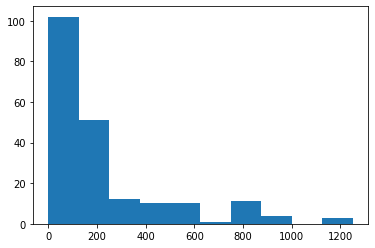

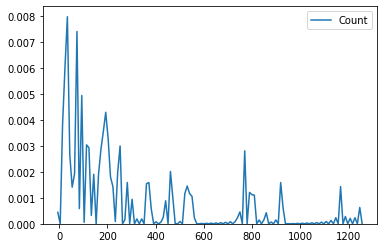

In [234]:
plt.hist(AnovaData['Count'])
plt.show()
sns.kdeplot(AnovaData['Count'],cumulative=False,bw=2)

In [143]:
# AnovaData['Count']=AnovaData['Count']+1

In [225]:
AnovaData.dtypes

density_Group     object
age_Group         object
newCount         float64
dtype: object

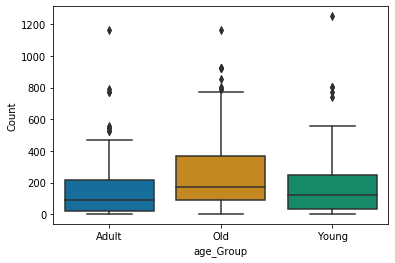

In [233]:
#Check for outliers
sns.boxplot(x='age_Group', y='Count', 
                 data=AnovaData, 
                 palette="colorblind")


In [236]:
AnovaData['Count']=AnovaData['Count'].astype(int)

In [237]:
# Data Transformation
AnovaData['newCount'],fitted_lambda = stats.boxcox(AnovaData['Count'])

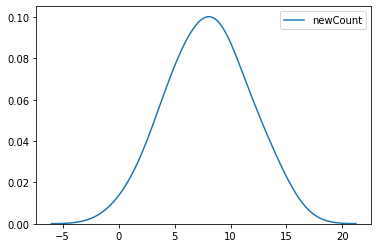

In [238]:
import matplotlib.pyplot as plt
sns.kdeplot(AnovaData['newCount'],cumulative=False,bw=2)

In [148]:
AnovaData.head()

,density_Group,age_Group,Count,newCount
0,Dense1,Adult,206,8.182329
1,Dense1,Adult,5,1.821831
2,Dense1,Adult,36,4.754236
3,Dense1,Adult,32,4.553696
4,Dense1,Adult,262,8.729745


In [152]:
AnovaData.shape

(204, 3)

In [153]:
AnovaData.isna().sum()

density_Group    0
age_Group        0
newCount         0
dtype: int64

In [239]:
# Fit the OlS model
#Approach 1.
model2 = ols('newCount ~ C(age_Group)+ C(density_Group)', AnovaData).fit()

print(f"Overall model F({model2.df_model: },{model2.df_resid: }) = {model2.fvalue: }, p = {model2.f_pvalue: }")
model2.summary()

Overall model F( 5.0, 198.0) =  33.512842550732266, p =  1.0326134879241319e-24


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               newCount   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     33.51
Date:                Wed, 13 May 2020   Prob (F-statistic):           1.03e-24
Time:                        20:24:15   Log-Likelihood:                -472.72
No. Observations:                 204   AIC:                             957.4
Df Residuals:                     198   BIC:                             977.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      5.8408      0.427     13.665      0.000       4.998       6.684
C(age_Group)[T.Old]            1.8152      0.427      4.247      0.000       0.972       2.658
C(age_Group)[T.Young]          0.5816      0.427      1.361      0.175      -0.261       1.425
C(density_Group)[T.Dense2]     4.7959      0.494      9.717      0.000       3.823       5.769
C(density_Group)[T.Dense3]    -0.7496      0.494     -1.519      0.130      -1.723       0.224
C(density_Group)[T.Dense4]     1.2143      0.494      2.460      0.015       0.241       2.188
==============================================================================
Omnibus:                       32.329   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.786
Skew:                          -0.956   Prob(JB):                     1.88e-10
Kurtosis:                       4.269   Cond. No.                         5.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [240]:
# Creates the ANOVA table
res2 = sm.stats.anova_lm(model2, typ=2)
res2

,sum_sq,df,F,PR(>F)
C(age_Group),116.843479,2.0,9.404867,1.253300e-04
C(density_Group),924.042364,3.0,49.584826,6.007121e-24
Residual,1229.948768,198.0,NaN,NaN


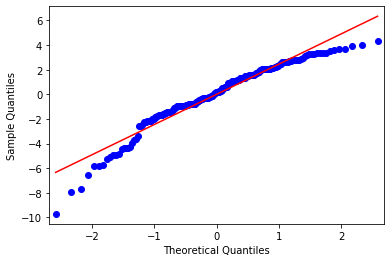

In [241]:
#Check the Normal distribution of residuals
res = model2.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [158]:
#As we can see that, residuals are almost normally distributed . Although points at the extreme ends can be discounted.

In [246]:
#Approach 2.
formula = 'newCount ~ C(age_Group) *C(density_Group)'
model = ols(formula, AnovaData).fit()

model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               newCount   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     14.98
Date:                Wed, 13 May 2020   Prob (F-statistic):           8.71e-21
Time:                        20:31:08   Log-Likelihood:                -472.07
No. Observations:                 204   AIC:                             968.1
Df Residuals:                     192   BIC:                             1008.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            5.5649      0.612      9.094      0.000       4.358       6.772
C(age_Group)[T.Old]                                  2.5162      0.865      2.908      0.004       0.809       4.223
C(age_Group)[T.Young]                                0.7083      0.865      0.819      0.414      -0.999       2.415
C(density_Group)[T.Dense2]                           5.0590      0.865      5.846      0.000       3.352       6.766
C(density_Group)[T.Dense3]                          -0.3141      0.865     -0.363      0.717      -2.021       1.393
C(density_Group)[T.Dense4]                           1.6194      0.865      1.871      0.063      -0.087       3.326
C(age_Group)[T.Old]:C(density_Group)[T.Dense2]      -0.6723      1.224     -0.549      0.583      -3.086       1.742
C(age_Group)[T.Young]:C(density_Group)[T.Dense2]    -0.1169      1.224     -0.096      0.924      -2.531       2.297
C(age_Group)[T.Old]:C(density_Group)[T.Dense3]      -1.0047      1.224     -0.821      0.413      -3.419       1.409
C(age_Group)[T.Young]:C(density_Group)[T.Dense3]    -0.3018      1.224     -0.247      0.805      -2.716       2.112
C(age_Group)[T.Old]:C(density_Group)[T.Dense4]      -1.1273      1.224     -0.921      0.358      -3.541       1.287
C(age_Group)[T.Young]:C(density_Group)[T.Dense4]    -0.0881      1.224     -0.072      0.943      -2.502       2.326
==============================================================================
Omnibus:                       34.200   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.587
Skew:                          -0.974   Prob(JB):                     1.71e-11
Kurtosis:                       4.429   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
aov_table = anova_lm(model, typ=2)
print(aov_table.round(4))

                                  sum_sq     df        F  PR(>F)
C(age_Group)                    116.8435    2.0   9.1781  0.0002
C(density_Group)                924.0424    3.0  48.3893  0.0000
C(age_Group):C(density_Group)     7.8047    6.0   0.2044  0.9751
Residual                       1222.1441  192.0      NaN     NaN


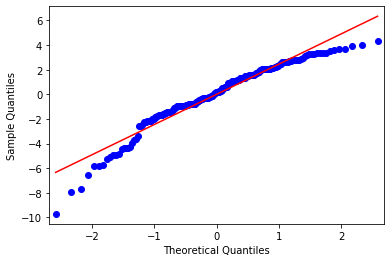

In [248]:
#Check the Normal distribution of residuals
res = model2.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [244]:
###Approch 3.

formula = 'newCount ~ C(age_Group) + C(density_Group) + C(age_Group):C(density_Group)'
model = ols(formula, AnovaData).fit()

model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               newCount   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     14.98
Date:                Wed, 13 May 2020   Prob (F-statistic):           8.71e-21
Time:                        20:30:45   Log-Likelihood:                -472.07
No. Observations:                 204   AIC:                             968.1
Df Residuals:                     192   BIC:                             1008.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            5.5649      0.612      9.094      0.000       4.358       6.772
C(age_Group)[T.Old]                                  2.5162      0.865      2.908      0.004       0.809       4.223
C(age_Group)[T.Young]                                0.7083      0.865      0.819      0.414      -0.999       2.415
C(density_Group)[T.Dense2]                           5.0590      0.865      5.846      0.000       3.352       6.766
C(density_Group)[T.Dense3]                          -0.3141      0.865     -0.363      0.717      -2.021       1.393
C(density_Group)[T.Dense4]                           1.6194      0.865      1.871      0.063      -0.087       3.326
C(age_Group)[T.Old]:C(density_Group)[T.Dense2]      -0.6723      1.224     -0.549      0.583      -3.086       1.742
C(age_Group)[T.Young]:C(density_Group)[T.Dense2]    -0.1169      1.224     -0.096      0.924      -2.531       2.297
C(age_Group)[T.Old]:C(density_Group)[T.Dense3]      -1.0047      1.224     -0.821      0.413      -3.419       1.409
C(age_Group)[T.Young]:C(density_Group)[T.Dense3]    -0.3018      1.224     -0.247      0.805      -2.716       2.112
C(age_Group)[T.Old]:C(density_Group)[T.Dense4]      -1.1273      1.224     -0.921      0.358      -3.541       1.287
C(age_Group)[T.Young]:C(density_Group)[T.Dense4]    -0.0881      1.224     -0.072      0.943      -2.502       2.326
==============================================================================
Omnibus:                       34.200   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.587
Skew:                          -0.974   Prob(JB):                     1.71e-11
Kurtosis:                       4.429   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [245]:
aov_table = statsmodels.stats.anova.anova_lm(model, typ=2)
print(aov_table)

                                    sum_sq     df          F        PR(>F)
C(age_Group)                    116.843479    2.0   9.178111  1.560282e-04
C(density_Group)                924.042364    3.0  48.389313  2.448503e-23
C(age_Group):C(density_Group)     7.804715    6.0   0.204355  9.751253e-01
Residual                       1222.144053  192.0        NaN           NaN


In [164]:
#Interpretation: The P-value obtained from ANOVA analysis for genotype, years, and interaction are statistically significant 
#(P<0.05). We conclude that type of density_Group significantly affects the corona cases outcome,
#age_Group significantly affects the corona cases outcome outcome, and interaction of both age_Group and density_Group 
#significantly affects the corona cases outcome outcome.

In [165]:
AnovaData.dtypes

density_Group     object
age_Group         object
newCount         float64
dtype: object

In [166]:
AnovaData.head()

,density_Group,age_Group,newCount
0,Dense1,Adult,8.182329
1,Dense1,Adult,1.821831
2,Dense1,Adult,4.754236
3,Dense1,Adult,4.553696
4,Dense1,Adult,8.729745


In [249]:
#Post hoc test
mc = statsmodels.stats.multicomp.MultiComparison(AnovaData['newCount'],AnovaData['density_Group'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Dense1 Dense2   4.7959  0.001  3.4645  6.1273   True
Dense1 Dense3  -0.7496 0.4656  -2.081  0.5818  False
Dense1 Dense4   1.2143 0.0876 -0.1171  2.5457  False
Dense2 Dense3  -5.5455  0.001 -6.8769 -4.2141   True
Dense2 Dense4  -3.5816  0.001  -4.913 -2.2502   True
Dense3 Dense4   1.9639  0.001  0.6325  3.2953   True
----------------------------------------------------


In [250]:
#Post hoc test
mc = statsmodels.stats.multicomp.MultiComparison(AnovaData['newCount'],AnovaData['age_Group'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 Adult    Old   1.8152 0.0041  0.4895 3.1409   True
 Adult  Young   0.5816 0.5519 -0.7441 1.9073  False
   Old  Young  -1.2336 0.0742 -2.5593 0.0921  False
---------------------------------------------------
